In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import json
import pickle


In [46]:
def load_data(folder_name):
    # load the synthetic results as dataframes in the synthetic_results folder
    results = {}
    for filename in os.listdir(folder_name):
        if filename.endswith('.csv'):
            df = pd.read_csv(f'{folder_name}/' + filename)
            df.drop(columns=['Unnamed: 0'], inplace=True)
            results[filename[:-4]] = df
            
    return results

In [47]:
synthetic_results = load_data("ablations/aci_grid_search/synthetic_results")
google_results = load_data("ablations/aci_grid_search/google_results")

In [48]:
def combine_arima_results(results_dict):
    """
    Combine the results of the arima models into a single dataframe.
    """
    arima_results = pd.DataFrame()
    for key in sorted(results_dict.keys(), key=lambda x: x[0].lower()):
        if "arima" in key:
            arima_results = pd.concat([arima_results, results_dict[key]], axis=0)
    arima_df = arima_results.groupby(arima_results.model_name).mean().reset_index()
    return arima_df

In [49]:
def combine_model_results(results_dict, model_name):
    """
    Combine the results of the models into a single dataframe.
    """
    model_results = pd.DataFrame()
    for key in sorted(results_dict.keys(), key=lambda x: x[0].lower()):
        if model_name in key:
            model_results = pd.concat([model_results, results_dict[key]], axis=0)
    model_df = model_results.groupby(model_results.model_name).mean().reset_index()
    return model_df

In [50]:
def concatenate_model_results(dataframes):
    """
    Concatenate the results of the models into a single dataframe.
    """
    model_results = pd.DataFrame()
    for df in dataframes:
        model_results = pd.concat([model_results, df], axis=0)
    model_df = model_results.groupby(model_results.model_name).mean().reset_index()
    return model_df


# Synthetic

In [51]:

# linear results
df_linear_syn = combine_model_results(synthetic_results, 'linear')

# forest results
df_forest_syn = combine_model_results(synthetic_results, 'forest')

# nn results
df_nn_syn = combine_model_results(synthetic_results, 'NN')

synthetic_results = { 'linear': df_linear_syn, 'forest': df_forest_syn, 'NN': df_nn_syn}
syn_df = concatenate_model_results(synthetic_results.values())

# Google

In [52]:

# linear results
df_linear_google = combine_model_results(google_results, 'linear')

# forest results
df_forest_google = combine_model_results(google_results, 'forest')

# nn results
df_nn_google = combine_model_results(google_results, 'NN')

google_results = { 'linear': df_linear_google, 'forest': df_forest_google, 'NN': df_nn_google}
google_df = concatenate_model_results(google_results.values())

# Create plots

NameError: name 'df' is not defined

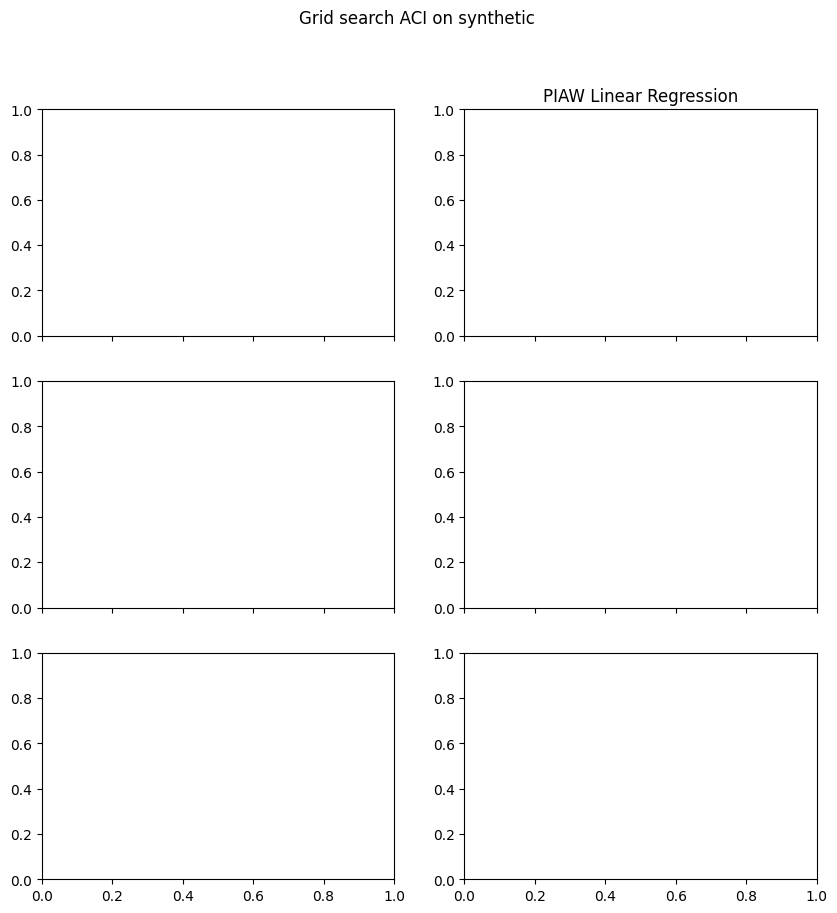

In [53]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True)
fig.set_size_inches(10, 10)
fig.suptitle("Grid search ACI on synthetic")

# linear regression
ax[0, 1].set_title("PIAW Linear Regression")
ax[0, 1].plot(df, scores_lin[:, 3].astype(float), label="QLR")  # piaw 
ax[0,1].scatter(gamma_lin, scores_lin[np.where(param_range == gamma_lin), 3].astype(float), color="red")
ax[0,1].set_xlabel("$\gamma$")
ax[0,1].set_ylabel("PIAW")
ax[0,1].legend(["PIAW", f"Optimal $\gamma$ = {gamma_lin.round(3)}"])

ax[0, 0].set_title("PICP Linear Regression")
ax[0,0].plot(param_range, scores_lin[:, 2].astype(float), label="QLR")  # picp
ax[0,0].scatter(gamma_lin, scores_lin[np.where(param_range == gamma_lin), 2].astype(float), color="red")
ax[0,0].set_xlabel("$\gamma$")
ax[0,0].set_ylabel("PICP")
ax[0,0].legend(["PICP", f"Optimal $\gamma$ = {gamma_lin.round(3)}"])


In [ ]:
synthetic_results["NN"]

,model_name,RMSE,PICP,PIAW,PINAW,CWC
0,NN ACI,10.375188,0.975,50.97718,0.526576,0.399911


In [ ]:
picp_column_idx = 2
piaw_column_idx = 3

In [ ]:
def get_picp_versus_piaw(results_dict, picp_column_idx, piaw_column_idx):
    df_linear = results_dict['linear']
    df_forest = results_dict['forest']
    df_nn = results_dict['NN']
    
    picp_piaw = {}
    
    # alphabetical order
    methods = ["ACI"]
    picp_piaw = {}
    
    for i, method in enumerate(methods):
        picp_piaw[method] = {}
        picp_piaw[method]["LR"] = df_linear[df_linear["model_name"] == f"Linear {method}"].iloc[0, [picp_column_idx, piaw_column_idx]].to_numpy()    
        picp_piaw[method]["RF"] = df_forest[df_forest["model_name"] == f"Forest {method}"].iloc[0, [picp_column_idx, piaw_column_idx]].to_numpy()    

        picp_piaw[method]["NN"] = df_nn[df_nn["model_name"] == f"NN {method}"].iloc[0, [picp_column_idx, piaw_column_idx]].to_numpy()    
    return picp_piaw
        
    

In [55]:
def plot_PIAW_versus_PICP(all_results, figsize=(20, 3)):
    assert len(all_results) > 0, "There should be at least 1 dataset"
    
    fig, axs = plt.subplots(1, len(all_results), figsize=figsize)
    
    if len(all_results) > 1:
        # TITLE
        fig.suptitle("PICP vs PIAW")
    
    best_coordinate = (0, 0)

    for i, (dataset, results) in enumerate(all_results.items()):
        picp_versus_piaw = get_picp_versus_piaw(results, picp_column_idx, piaw_column_idx)
        # CQR = picp_versus_piaw["CQR"]
        ACI = picp_versus_piaw["ACI"]
        # ENBPI = picp_versus_piaw["EnbPI"]
        # ENCQR = picp_versus_piaw["EnCQR"]
        
        ax = axs[i] if len(all_results) > 1 else axs

        # plot data on the figure

        # PICP and PIAW scores
        
        # markers
        markers = {"LR" : "*", "RF" : "^", "NN" : "s"}

        legends_mark = []
        legends_name = []
        # plot the data
        for j, (model, marker) in enumerate(markers.items()):
            # a = ax.scatter(CQR[model][0],CQR[model][1], marker=marker,  color='lightblue', linewidth=3)
            b = ax.scatter(ACI[model][0],ACI[model][1], marker=marker, color='tomato', linewidth=3)
            # c = ax.scatter(ENBPI[model][0],ENBPI[model][1], marker=marker, color='gold', linewidth=3)
            # d = ax.scatter(ENCQR[model][0],ENCQR[model][1], marker=marker, color='green', linewidth=3)
            
            # red_patch = mpatches.Patch(color='red', label='The red data')
            legends_mark.append([b])
            legends_name.append([f"{model}-ACI"])
            
        
        # AX LABELS
        ax.set_xlabel('PICP')
        ax.set_ylabel('PIAW')
        
        ax.set_title(dataset)


        # TICKS
        # ax.set_xticks(np.arange(0.7, 1.05, 0.1))


        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])



    
    # LEGEND
    legends_mark = np.array(legends_mark).T.flatten()
    legends_name = np.array(legends_name).T.flatten()
    # Put a legend to the right of the current axis
    plt.legend(legends_mark, legends_name, ncol=4, loc='center', bbox_to_anchor=(0.5, -0.25))
    
    
    fig.tight_layout()

In [61]:
# load the previous results
prev_synthetic_results = load_data("main_results/synthetic_results")
prev_google_results = load_data("main_results/google_results")

# linear results
df_prev_linear_syn = combine_model_results(prev_synthetic_results, 'linear')

# forest results
df_prev_forest_syn = combine_model_results(prev_synthetic_results, 'forest')

# nn results
df_prev_nn_syn = combine_model_results(prev_synthetic_results, 'NN')

synthetic_prev_results = {'linear': df_prev_linear_syn, 'forest': df_prev_forest_syn, 'NN': df_prev_nn_syn}
df_syn_prev = concatenate_model_results(prev_synthetic_results.values())


# linear results
df_prev_linear_google = combine_model_results(prev_google_results, 'linear')

# forest results
df_prev_forest_google = combine_model_results(prev_google_results, 'forest')

# nn results
df_prev_nn_google = combine_model_results(prev_google_results, 'NN')

google_prev_results = {'linear': df_prev_linear_google, 'forest': df_prev_forest_google, 'NN': df_prev_nn_google}
df_syn_prev = concatenate_model_results(prev_google_results.values())

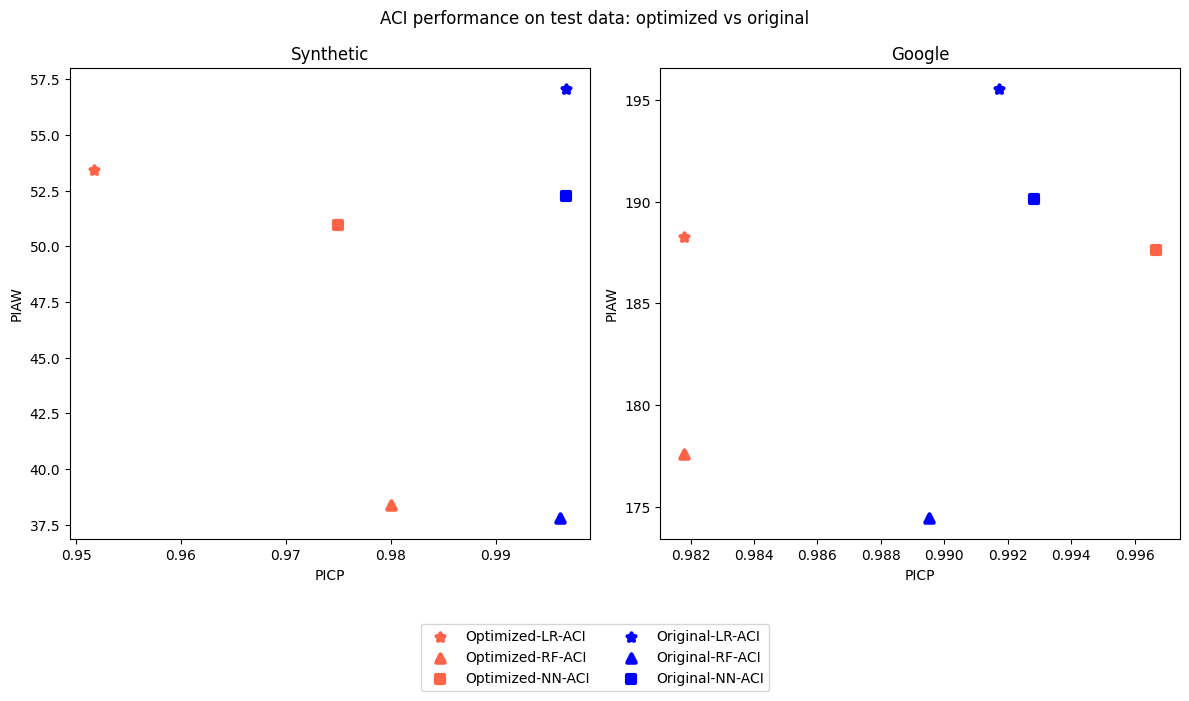

In [104]:
fig, ax = plt.subplots(1,2, figsize=(20, 3))
fig.set_size_inches(12, 6)

for i, results in enumerate([(synthetic_results, 
                              synthetic_prev_results), 
                             (google_results, 
                              google_prev_results)]):
    
    
    res, prev_res = results
    picp_versus_piaw = get_picp_versus_piaw(res, picp_column_idx, piaw_column_idx)

    ACI = picp_versus_piaw["ACI"]

    # markers
    markers = {"LR" : "*", "RF" : "^", "NN" : "s"}

    legends_mark = []
    legends_name = []
    # plot the data
    for j, (model, marker) in enumerate(markers.items()):
        b = ax[i].scatter(ACI[model][0],ACI[model][1], marker=marker, color='tomato', linewidth=3)

        legends_mark.append([b])
        legends_name.append([f"Optimized-{model}-ACI"])
        
    picp_versus_piaw = get_picp_versus_piaw(prev_res, picp_column_idx, piaw_column_idx)

    ACI = picp_versus_piaw["ACI"]

    # markers
    markers = {"LR" : "*", "RF" : "^", "NN" : "s"}

    # plot the data
    for j, (model, marker) in enumerate(markers.items()):
        b = ax[i].scatter(ACI[model][0],ACI[model][1], marker=marker, color='blue', linewidth=3)

        legends_mark.append([b])
        legends_name.append([f"Original-{model}-ACI"])



    ax[i].set_xlabel('PICP')
    ax[i].set_ylabel('PIAW')

ax[0].set_title("Synthetic")
ax[1].set_title("Google")

fig.suptitle("ACI performance on test data: optimized vs original")
# LEGEND
legends_mark = np.array(legends_mark).T.flatten()
legends_name = np.array(legends_name).T.flatten()
fig.legend(legends_mark, legends_name, ncol=2, loc='center', bbox_to_anchor=(0.5, -0.1))
fig.tight_layout()

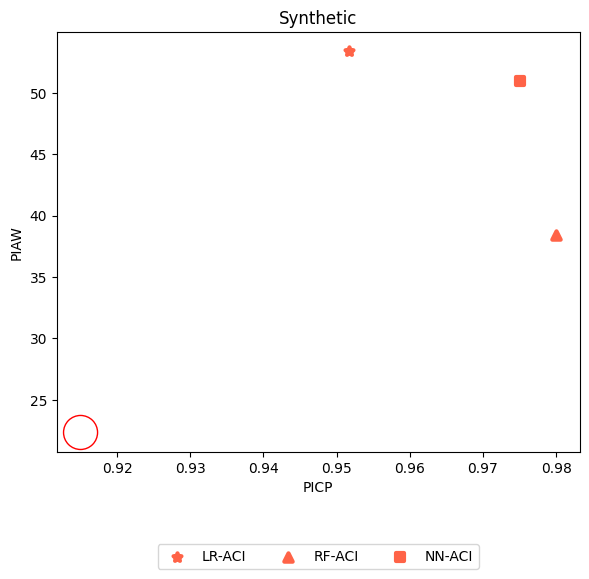

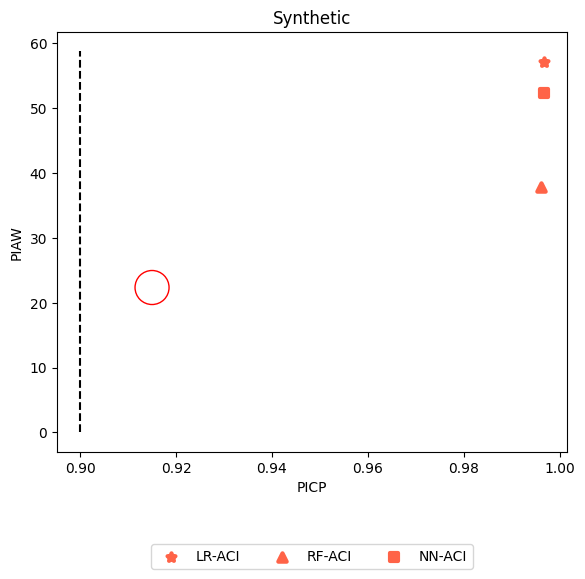

In [62]:
plot_PIAW_versus_PICP({"Synthetic" : synthetic_results}, figsize=(6, 6))
plt.scatter(0.915000 , 22.338324, s=600, facecolors='none', edgecolors='r')


plot_PIAW_versus_PICP({"Synthetic" : synthetic_prev_results}, figsize=(6, 6))
plt.scatter(0.915000 , 22.338324, s=600, facecolors='none', edgecolors='r')
ax = plt.gca()
maximum = ax.get_ylim()[1]
plt.vlines(0.9, 0, maximum, colors='k', linestyles='dashed', label='PICP=0.9')


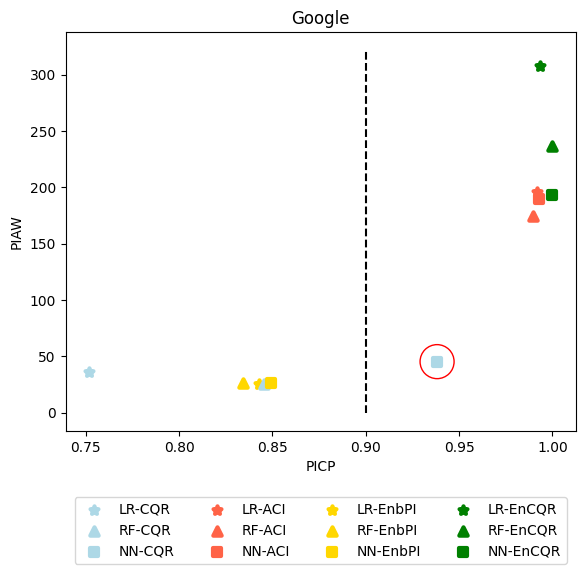

In [ ]:
plot_PIAW_versus_PICP({"Google" : google_results}, figsize=(6, 6))
plt.scatter(0.938190, 45.344037, s=600, facecolors='none', edgecolors='r')
ax = plt.gca()
maximum = ax.get_ylim()[1]
plt.vlines(0.9, 0, maximum, colors='k', linestyles='dashed', label='PICP=0.9')

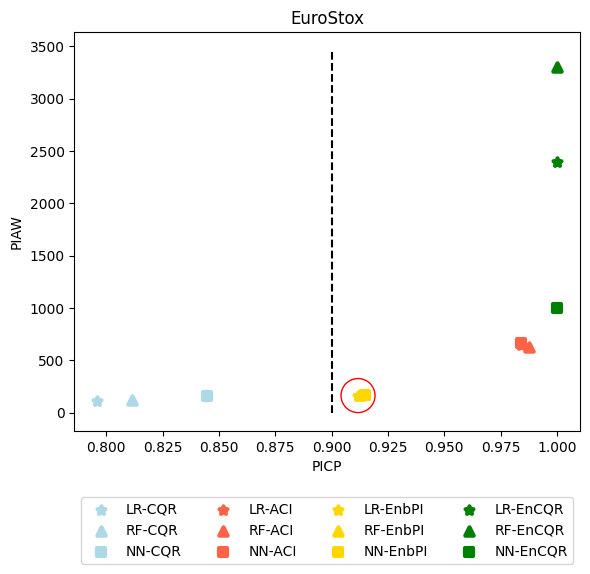

In [ ]:
plot_PIAW_versus_PICP({"EuroStox" : eurostox_results}, figsize=(6, 6))
plt.scatter(0.911692, 163.830789, s=600, facecolors='none', edgecolors='r')
ax = plt.gca()
maximum = ax.get_ylim()[1]
plt.vlines(0.9, 0, maximum, colors='k', linestyles='dashed', label='PICP=0.9')

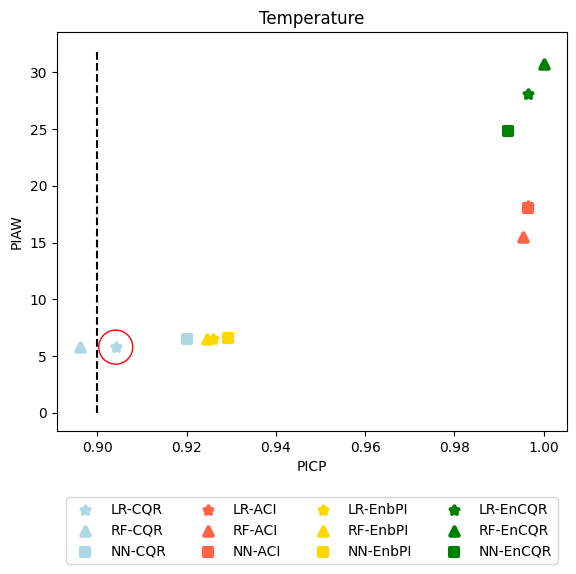

In [ ]:
plot_PIAW_versus_PICP({"Temperature" : temperature_results}, figsize=(6, 6))
plt.scatter(0.904110, 5.782, s=600, facecolors='none', edgecolors='r')
ax = plt.gca()
maximum = ax.get_ylim()[1]
plt.vlines(0.9, 0, maximum, colors='k', linestyles='dashed', label='PICP=0.9')

# For the table

In [ ]:
for dataset, results in synthetic_results.items():
    print(dataset)
    print(results)

arima
  model_name      RMSE   PICP      PIAW     PINAW       CWC
0      ARIMA  5.860662  0.915  19.58261  0.202281  0.792352
linear
     model_name      RMSE      PICP       PIAW     PINAW       CWC
0    Linear ACI  8.045551  0.996667  57.049297  0.589299  0.310298
1    Linear CQR  8.045551  0.856667  36.973091  0.381919  0.584225
2  Linear EnCQR  8.212838  1.000000  91.289444  0.942987  0.042236
3  Linear EnbPI  7.431642  0.945556  28.207327  0.291371  0.665844
forest
     model_name      RMSE      PICP        PIAW     PINAW       CWC
0    Forest ACI  6.416332  0.996111   37.814818  0.390613  0.461874
1    Forest CQR  6.416332  0.915000   22.338324  0.230747  0.763954
2  Forest EnCQR  6.380206  0.962778  106.965855  1.104918 -0.093216
3  Forest EnbPI  6.353832  0.953333   24.956029  0.257787  0.681477
NN
  model_name      RMSE      PICP       PIAW     PINAW       CWC
0     NN ACI  7.039244  0.996667  52.266275  0.539892  0.347344
1     NN CQR  7.039244  0.954444  34.175969  0.353025 